In [1]:
import sys
sys.path.append('../')
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
from panav.env import NavigationEnv, Box2DRegion, PolygonRegion, box_2d_center, line_seg_to_obstacle
from panav.viz import draw_env
%load_ext autoreload
%autoreload 2

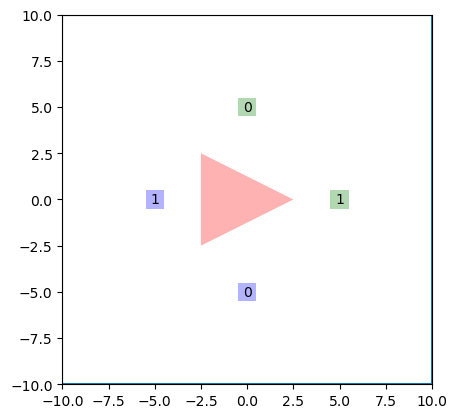

In [44]:

start_locs = np.array([[0,-5],[-5,0]])
goal_locs = np.array([[0,5],[5,0]])


start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

starts = [box_2d_center(s,start_box_side) for s in start_locs]

goals = [box_2d_center(g,goal_box_side) for g in goal_locs]


limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 

O1 = PolygonRegion([(-2.5,2.5),(-2.5,-2.5),(2.5,0)])


env = NavigationEnv(limits,[O1],starts,goals)

draw_env(env)

## ORCA: a distributed local collision avoidance protocol

ORCA paper source: https://gamma.cs.unc.edu/ORCA/publications/ORCA.pdf

ORCA runs on every individual agent.

Input(for the ORCA algorithm on each agent):
* The locations and 'optimization velocities' $v_{opt}$ of neighboring agents.
* The location and 'optimization velocity' of the agent itself.
* The 'preferred velcoity' $v_{pref}$ of the agent itself.
* Desired safe time interval projected forward $\tau$.
* bloating radius of the agents.
* Static obstacles.

Output:
* A safe velocity $v$ to be traveled at for the next $\tau$ seconds.

# Step 1: avoiding a static obstacle(polygon)

In simulation, would need to compute which face of the polygon is closest to the agent, and compute the corresponding velocity obstacle thereof.

In [45]:

def safe_v(env,x,v_pref,tau,bloating_r):
    

    v_out = cp.Variable(v_pref.shape)
    constraints = []
    
    obstacle_d = [] # Directions of static obstacles
    for O in env.obstacles: 
        obstacle_d.append(O.project(x) - x)
        
    for d in obstacle_d:
        l = np.linalg.norm(d)
        constraints.append(d/l @ (v_out*tau) <= (l-bloating_r))

    prob = cp.Problem(cp.Minimize(cp.norm(v_pref-v_out)),constraints)
    prob.solve()
    return v_out.value

In [52]:
bloating_r = 0.5
tau = 1.0

d = 2
K = 10
t0 = 0
vmax = 1.0
interp_dt = 0.1

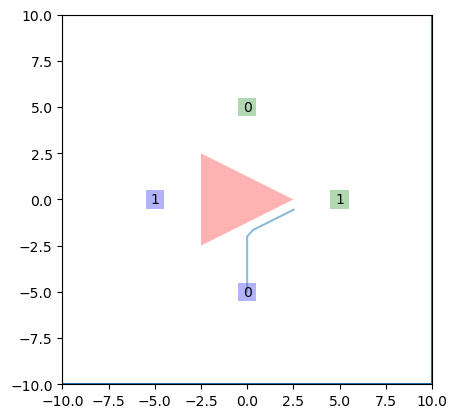

In [53]:

x = start_locs[0]*1.0
goal_loc = goals[0].project(x)


pos = []
for _ in range(200):
    pos.append(np.array(x))
    v_pref = vmax * (goal_loc-x)/np.linalg.norm(goal_loc-x)
    v = safe_v(env,x,v_pref,tau,bloating_r)
    # print(v)
    x += v * tau
    
ax = plt.gca()
draw_env(env,[np.array(pos).T],ax)

# Step 2: avoid other agents that also implement the ORCA protocol.